In [1]:

# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES
# TO THE CORRECT LOCATION (/kaggle/input) IN YOUR NOTEBOOK,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

import os
import sys
from tempfile import NamedTemporaryFile
from urllib.request import urlopen
from urllib.parse import unquote, urlparse
from urllib.error import HTTPError
from zipfile import ZipFile
import tarfile
import shutil

CHUNK_SIZE = 40960
DATA_SOURCE_MAPPING = 'image-caption-dataset:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5303068%2F8815748%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240629%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240629T152915Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3Dc50a942587a375cef65c6f2b1921e8e17e647565df1a59a33fc7cd835dd79add080a1f169f99039ccc0f1da3b2eabdfee0233d11e8611705668cde6aa2c44a7c870c4aacb53930aab881487877eb09f49e9f9e521e1b630107625e0f1fd4a80218c7dc4e15ff30a5440e9a1307a9af46d23a21a40bf13b74313259471e40d21403a09564a0279957c469bc4d6a783d56612cdffab13248c2210d160a34210246d7267bd85fc4fde163d39f3e9fdf49381557f91a740835aa7309840fcd88d4c87c8f4d9f85155e5e1b8915f4d5795c8d1e4072f4d2fa01c08e54e066e0b20c01e87ac77c97a32226be6cf55b8227e57dbaffeb5b4b5c719e044ad3efa417ae15,image-features:https%3A%2F%2Fstorage.googleapis.com%2Fkaggle-data-sets%2F5303324%2F8816103%2Fbundle%2Farchive.zip%3FX-Goog-Algorithm%3DGOOG4-RSA-SHA256%26X-Goog-Credential%3Dgcp-kaggle-com%2540kaggle-161607.iam.gserviceaccount.com%252F20240629%252Fauto%252Fstorage%252Fgoog4_request%26X-Goog-Date%3D20240629T152915Z%26X-Goog-Expires%3D259200%26X-Goog-SignedHeaders%3Dhost%26X-Goog-Signature%3D93503f76f0c09d0753150f91592a9607f80f533f310284476b78bc077d832336eccf39fb74c89125703eec677135be203992b62d640e3fe7e4e7154a811f3314849b8c511572d8dcce6196548108aa29f6a19dcbe8c1378cdf79f1bb4445ef8fcda64dc476b33b6ec3ceffdad75ab2a4bc91062c66800564de7593faf803a6beef2f4261ce9405d43041e2e9a78807cea03d83ba70d0e8b895a8f826929380d4e32a0355dce05f385fe14311436ede4c0647365669acf459dac1f85b3f65c0ebdf4a42196a3c18f84fdb2e0d137f07da0543b1fa43dcfd2b39da7b619721d168b004165962a2d1e64a9e0edef8ee6582e0e181abf771ee5b355ebc282a761295'

KAGGLE_INPUT_PATH='/kaggle/input'
KAGGLE_WORKING_PATH='/kaggle/working'
KAGGLE_SYMLINK='kaggle'

!umount /kaggle/input/ 2> /dev/null
shutil.rmtree('/kaggle/input', ignore_errors=True)
os.makedirs(KAGGLE_INPUT_PATH, 0o777, exist_ok=True)
os.makedirs(KAGGLE_WORKING_PATH, 0o777, exist_ok=True)

try:
  os.symlink(KAGGLE_INPUT_PATH, os.path.join("..", 'input'), target_is_directory=True)
except FileExistsError:
  pass
try:
  os.symlink(KAGGLE_WORKING_PATH, os.path.join("..", 'working'), target_is_directory=True)
except FileExistsError:
  pass

for data_source_mapping in DATA_SOURCE_MAPPING.split(','):
    directory, download_url_encoded = data_source_mapping.split(':')
    download_url = unquote(download_url_encoded)
    filename = urlparse(download_url).path
    destination_path = os.path.join(KAGGLE_INPUT_PATH, directory)
    try:
        with urlopen(download_url) as fileres, NamedTemporaryFile() as tfile:
            total_length = fileres.headers['content-length']
            print(f'Downloading {directory}, {total_length} bytes compressed')
            dl = 0
            data = fileres.read(CHUNK_SIZE)
            while len(data) > 0:
                dl += len(data)
                tfile.write(data)
                done = int(50 * dl / int(total_length))
                sys.stdout.write(f"\r[{'=' * done}{' ' * (50-done)}] {dl} bytes downloaded")
                sys.stdout.flush()
                data = fileres.read(CHUNK_SIZE)
            if filename.endswith('.zip'):
              with ZipFile(tfile) as zfile:
                zfile.extractall(destination_path)
            else:
              with tarfile.open(tfile.name) as tarfile:
                tarfile.extractall(destination_path)
            print(f'\nDownloaded and uncompressed: {directory}')
    except HTTPError as e:
        print(f'Failed to load (likely expired) {download_url} to path {destination_path}')
        continue
    except OSError as e:
        print(f'Failed to load {download_url} to path {destination_path}')
        continue

print('Data source import complete.')


[==================================================] 1113084437 bytes downloaded
Downloaded and uncompressed: image-caption-dataset
[==================================================] 47586926 bytes downloaded
Downloaded and uncompressed: image-features
Data source import complete.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Image Caption Generator using CNN and RNN

In this notebook, we will implement an image caption generator using a combination of Convolutional Neural Networks (CNN) and Recurrent Neural Networks (RNN).
* CNN - act as an encoder to extract features from the images.
* RNN - act as a decoder to generate the captions.

## Import Libraries

In [2]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm
from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add
import matplotlib.pyplot as plt

## Data Loading and Preprocessing

In [3]:
# the directories to use the data
BASE_DIR = '/kaggle/input/image-caption-dataset'
WORKING_DIR = '/kaggle/working'

### Preprocess images

***Function to load and preprocess a single image***

In [4]:
def load_and_preprocess_image(img_path, target_size=(224, 224)):
    """
    Load and preprocess a single image from the given path.

    Args:
    - img_path (str): Path to the image file.
    - target_size (tuple): Target size to resize the image.

    Returns:
    - numpy.ndarray: Preprocessed image as a numpy array.
    """
    # load the image from file
    image = load_img(img_path, target_size=target_size)
    # converts it image pixels to numpy array
    image = img_to_array(image)
    # reshapes it
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # preprocess it for VGG16
    image = preprocess_input(image)
    return image

***Function to extract features from a single image using a pre-trained VGG16 model***

In [5]:
def extract_features_from_image(model, image):
    """
    Extract features from a single image using a pre-trained model.

    Args:
    - model (tensorflow.keras.Model): Pre-trained model (VGG16).
    - image (numpy.ndarray): Preprocessed image as a numpy array.

    Returns:
    - numpy.ndarray: Extracted features from the image.
    """
    # extract features
    feature = model.predict(image, verbose=0)
    return feature

***Function to extract features from all images in a directory***

We don't want the fully connected layers of the VGG16 model; we only need the previous convolutional layers to extract feature results.

In [6]:
def extract_features(directory):
    """
    Extract features from all images in a directory using a pre-trained model.

    Args:
    - directory (str): Directory path containing images.

    Returns:
    - dict: Dictionary mapping image IDs to their extracted features.
    """
    # load the pre-trained VGG16 model
    base_model = VGG16()
    # restructure the model
    model = Model(inputs=base_model.inputs, outputs=base_model.layers[-2].output)
    # summarize
    print(model.summary())

    # Dictionary to store image features
    features = {}

    # Loop through all images in the directory
    for img_name in tqdm(os.listdir(directory)):
        img_path = os.path.join(directory, img_name)
        # Load and preprocess the image
        image = load_and_preprocess_image(img_path)
        # Extract features
        feature = extract_features_from_image(model, image)
        # Get image ID (image names are in the format 'imageid.jpg')
        image_id = os.path.splitext(img_name)[0]
        # Store the features in the dictionary
        features[image_id] = feature

    return features

Calls the `extract_features` function to get the features for all images in the directory.

In [42]:
image_directory = os.path.join(BASE_DIR, 'Images/Images')
# /kaggle/input/image-caption-dataset/Images/Images
image_features = extract_features(image_directory)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0   

  0%|          | 0/8091 [00:00<?, ?it/s]

In [43]:
# store features in pickle
pickle.dump(image_features, open(os.path.join(WORKING_DIR, 'image_features.pkl'), 'wb'))

In [8]:
# load features from pickle
with open(os.path.join('/kaggle/input/image-features', 'image_features.pkl'), 'rb') as f:
    image_features = pickle.load(f)

### Preprocess captions

***Load Captions Data***

In [9]:
# Load the captions data from the text file
captions_file = os.path.join(BASE_DIR, 'captions.txt')

with open(captions_file, 'r') as f:
    next(f)  # Skip header
    captions_doc = f.read()

In [10]:
# split and append the captions data with the image
# create mapping of image IDs to captions
mapping = {}
# process lines
for line in tqdm(captions_doc.split('\n')):
    # split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # remove extension from image ID
    image_id = image_id.split('.')[0]
    # Combine list of caption tokens into a single string
    caption = " ".join(caption)
    # create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

***Clean and Preprocess Captions***

In [11]:
def clean_captions(mapping):
    """
        Clean and preprocess captions in the mapping dictionary by converting to lowercase,
        removing non-alphabetic characters, and adding <start> and <end> tokens.

        Args:
        - mapping (dict): Dictionary mapping image IDs to lists of captions.

        Returns:
        - None. Modifies captions in-place in the mapping dictionary.
    """
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # take one caption at a time
            caption = captions[i]
            # preprocessing steps
            # convert to lowercase
            caption = caption.lower()
            # Remove non-alphabetic characters
            caption = caption.replace('[^A-Za-z]', '')
            # Remove extra spaces
            caption = caption.strip()
            # add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

visualize the text before and after cleaning

In [12]:
# before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [13]:
# Clean and preprocess the captions with <start> and <end> tokens
clean_captions(mapping)

In [14]:
# after preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [15]:
# 'mapping' dictionary containing image IDs as keys
num_images = len(mapping)
print("Number of unique images:", num_images)

Number of unique images: 8091


In [16]:
# store the preprocessed captions into a list
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [17]:
num_captions = len(all_captions)
print("Number of preprocessed captions:", num_captions)

Number of preprocessed captions: 40455


In [18]:
print("First 10 preprocessed captions:")
for i, caption in enumerate(all_captions[:10]):
    print(f"{i+1}: {caption}")

First 10 preprocessed captions:
1: startseq child in pink dress is climbing up set of stairs in an entry way endseq
2: startseq girl going into wooden building endseq
3: startseq little girl climbing into wooden playhouse endseq
4: startseq little girl climbing the stairs to her playhouse endseq
5: startseq little girl in pink dress going into wooden cabin endseq
6: startseq black dog and spotted dog are fighting endseq
7: startseq black dog and tri-colored dog playing with each other on the road endseq
8: startseq black dog and white dog with brown spots are staring at each other in the street endseq
9: startseq two dogs of different breeds looking at each other on the road endseq
10: startseq two dogs on pavement moving toward each other endseq


## Tokenization and Vocabulary Creation

**Tokenization** is the process of converting text (in this case, captions) into a sequence of tokens (words or subwords). Each token typically represents a meaningful unit that the model can work with.

* Caption: "A cat is sitting on a mat."
* Tokenization: ["A", "cat", "is", "sitting", "on", "a", "mat", "."].

**Vocabulary creation** involves generating a list of all unique tokens (words) that appear in the dataset. Each unique token is assigned a unique integer index.

In [19]:
# tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)

In [20]:
print("First 10 words in the vocabulary:", {index: tokenizer.index_word[index] for index in range(1, 11)})

First 10 words in the vocabulary: {1: 'startseq', 2: 'endseq', 3: 'in', 4: 'the', 5: 'on', 6: 'is', 7: 'and', 8: 'dog', 9: 'with', 10: 'man'}


In [21]:
tokenizer.word_index.get('steps')

309

In [22]:
vocab_size = len(tokenizer.word_index) + 1
print(f'Vocabulary size: {vocab_size}')

Vocabulary size: 8485


**Padding sequences** involves ensuring that all sequences (captions) have the same length. Neural networks require fixed-size inputs, so sequences shorter than a specified length are padded with a special token (usually 0) to match the desired length.

In [23]:
# get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
print(f'Maximum caption length: {max_length}')

Maximum caption length: 35


In [24]:
# Convert captions to sequences of word indices
sequences = tokenizer.texts_to_sequences(all_captions)
print('Captions as sequences of indices:')
for seq in sequences[:10]:
    print(seq)

Captions as sequences of indices:
[1, 42, 3, 90, 172, 6, 119, 50, 393, 11, 394, 3, 27, 5146, 670, 2]
[1, 18, 316, 64, 196, 117, 2]
[1, 39, 18, 119, 64, 196, 2429, 2]
[1, 39, 18, 119, 4, 394, 19, 60, 2429, 2]
[1, 39, 18, 3, 90, 172, 316, 64, 196, 2973, 2]
[1, 14, 8, 7, 843, 8, 16, 343, 2]
[1, 14, 8, 7, 1568, 235, 8, 33, 9, 137, 82, 5, 4, 151, 2]
[1, 14, 8, 7, 13, 8, 9, 26, 1001, 16, 640, 21, 137, 82, 3, 4, 72, 2]
[1, 12, 30, 11, 741, 2645, 89, 21, 137, 82, 5, 4, 151, 2]
[1, 12, 30, 5, 727, 805, 321, 137, 82, 2]


In [25]:
# Pad sequences to ensure uniform length
padded_sequences = pad_sequences(sequences, maxlen=max_length, padding='post')
print('Padded sequences:')
print(padded_sequences[:2])

Padded sequences:
[[   1   42    3   90  172    6  119   50  393   11  394    3   27 5146
   670    2    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]
 [   1   18  316   64  196  117    2    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0]]


## Train Test Split

Assign the first 90% of the image IDs to the *training* set and rest of them are *testing* set

In [26]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

# Print the number of images in the training and testing sets
print(f"Number of training images: {len(train)}")
print(f"Number of testing images: {len(test)}")

Number of training images: 7281
Number of testing images: 810


In [27]:
# create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    """
    A data generator to yield batches of data with padded sequences for training.

    Parameters:
    - data_keys: List of image IDs to process.
    - mapping: Dictionary mapping image IDs to their corresponding captions.
    - features: Dictionary mapping image IDs to their corresponding image features.
    - tokenizer: Fitted tokenizer to convert text to sequences.
    - max_length: Maximum length of the sequences.
    - vocab_size: Size of the vocabulary.
    - batch_size: Number of samples per batch.

    Yields:
    - A tuple (inputs, outputs) where inputs is a dictionary with keys 'image_input' and 'text_input',
      and outputs is the target word.
    """
    # loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # process each caption
            for caption in captions:
                # encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image_input": X1, "text_input": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

In [28]:
# Assuming you have defined your data generator like this
generator = data_generator(train, mapping, image_features, tokenizer, max_length, vocab_size, batch_size=32)

# Iterate through the generator to view some samples
for i, batch in enumerate(generator):
    if i >= 5:  # Print only the first 5 batches for example
        break

    # Accessing batch inputs and outputs
    input_data = batch[0]
    toutput_data = batch[1]

    print(f"Batch {i + 1}:")
    print(f"Image shape: {input_data['image_input'].shape}")
    print(f"Text shape: {input_data['text_input'].shape}")
    print(f"Output shape: {toutput_data.shape}")
    print("\n")

Batch 1:
Image shape: (1749, 4096)
Text shape: (1749, 35)
Output shape: (1749, 8485)


Batch 2:
Image shape: (1667, 4096)
Text shape: (1667, 35)
Output shape: (1667, 8485)


Batch 3:
Image shape: (1584, 4096)
Text shape: (1584, 35)
Output shape: (1584, 8485)


Batch 4:
Image shape: (1670, 4096)
Text shape: (1670, 35)
Output shape: (1670, 8485)


Batch 5:
Image shape: (1689, 4096)
Text shape: (1689, 35)
Output shape: (1689, 8485)




## Model Architecture

 we define and compile the encoder-decoder model for the image caption generator.

In [29]:
from keras.layers import Input, Dropout, Dense, Embedding, LSTM, add
from keras.models import Model
from keras.utils import plot_model

def create_model(vocab_size, max_length):
    """
    Create the encoder-decoder model for image caption generation.

    Parameters:
    - vocab_size: Size of the vocabulary.
    - max_length: Maximum length of the sequences.

    Returns:
    - model: Compiled Keras model.
    """
    # Encoder Model
    # Image feature layers
    image_input = Input(shape=(4096,), name="image_input")
    fe1 = Dropout(0.4)(image_input)
    fe2 = Dense(256, activation='relu')(fe1)
    # Sequence feature layers
    text_input = Input(shape=(max_length,), name="text_input")
    embedding = Embedding(vocab_size, 256, mask_zero=True)(text_input)
    embedding_dropout = Dropout(0.4)(embedding)
    lstm = LSTM(256)(embedding_dropout)

    # Decoder model
    decoder1 = add([fe2, lstm])
    decoder2 = Dense(256, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Compile the model
    model = Model(inputs=[image_input, text_input], outputs=outputs)
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    # summarize model
    print(model.summary())
    plot_model(model, to_file='model.png', show_shapes=True)

    return model

# Create and compile the model
model = create_model(vocab_size, max_length)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 text_input (InputLayer)     [(None, 35)]                 0         []                            
                                                                                                  
 image_input (InputLayer)    [(None, 4096)]               0         []                            
                                                                                                  
 embedding (Embedding)       (None, 35, 256)              2172160   ['text_input[0][0]']          
                                                                                                  
 dropout (Dropout)           (None, 4096)                 0         ['image_input[0][0]']         
                                                                                            

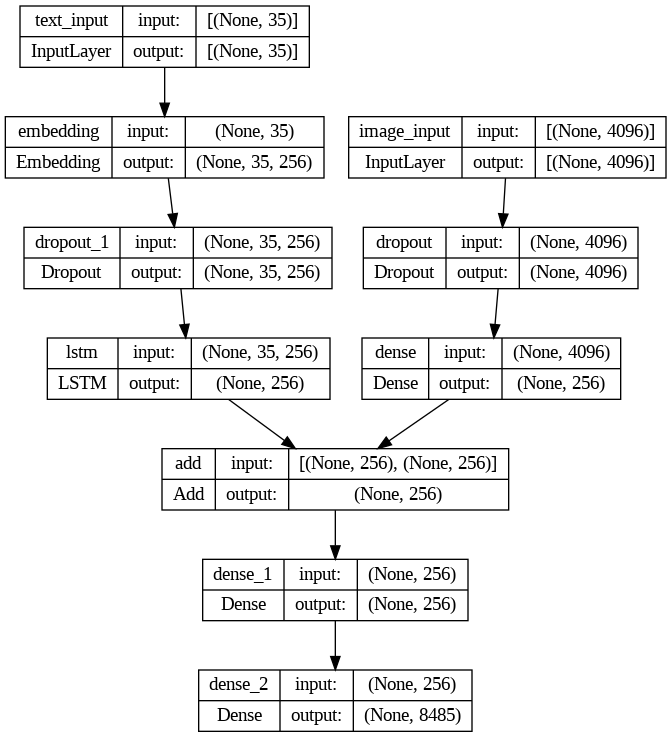

In [30]:
# Plot the model with explicit show
plot_model(model, show_shapes=True, to_file='model_plot.png')

## Training the Model

In [31]:
import tensorflow as tf
# Check if GPU is available
if tf.config.list_physical_devices('GPU'):
    print("GPU is available")
else:
    print("GPU is not available, training might be slower")

GPU is available


227/227 [==============================] - 74s 288ms/step - loss: 5.2350 - accuracy: 0.1508


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


227/227 [==============================] - 58s 256ms/step - loss: 1.9627 - accuracy: 0.4834


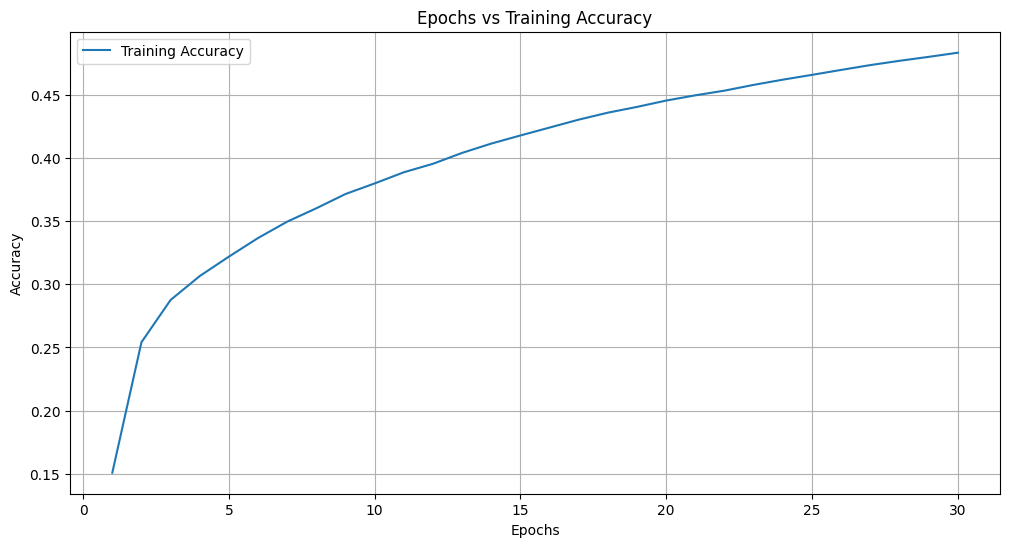

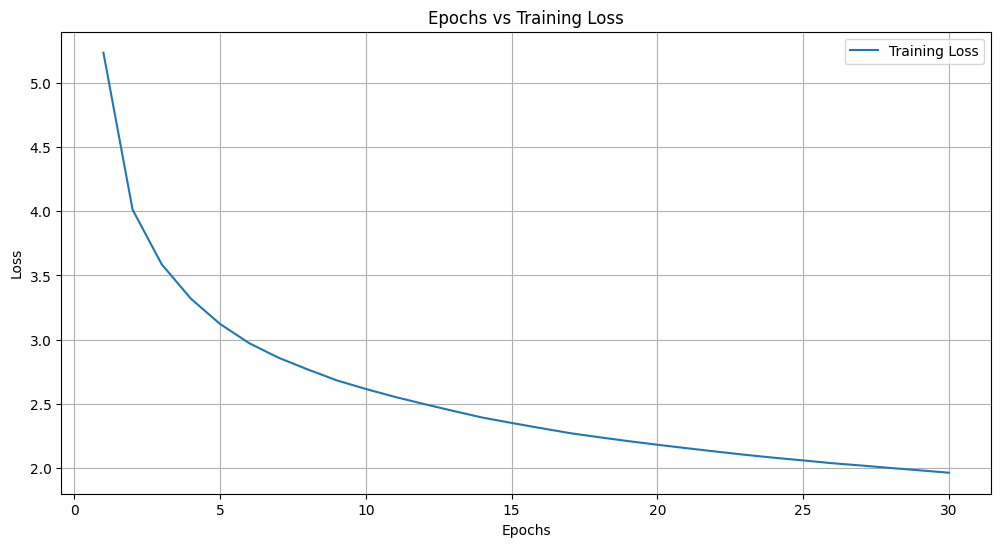

In [32]:
from keras.callbacks import ModelCheckpoint

def train_model(model, train, mapping, features, tokenizer, max_length, vocab_size, batch_size, epochs):
    """
    Train the image captioning model and plot accuracy and loss over epochs.

    Parameters:
    - model: Compiled Keras model.
    - train: List of image IDs for training.
    - mapping: Dictionary mapping image IDs to their corresponding captions.
    - features: Dictionary mapping image IDs to their corresponding image features.
    - tokenizer: Fitted tokenizer to convert text to sequences.
    - max_length: Maximum length of the sequences.
    - vocab_size: Size of the vocabulary.
    - batch_size: Number of samples per batch.
    - epochs: Number of training epochs.
    """
    steps = len(train) // batch_size

    # Lists to store history
    history_acc = []
    history_loss = []

    for i in range(epochs):
        # Create data generator
        generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)

        # Fit for one epoch
        history = model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

        # Save history
        history_acc.append(history.history['accuracy'])
        history_loss.append(history.history['loss'])

        # Save the model after each epoch
        model.save(f'model_epoch_{i+1}.h5')

    # Plot accuracy
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), history_acc, label='Training Accuracy')
    plt.title('Epochs vs Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Plot loss
    plt.figure(figsize=(12, 6))
    plt.plot(range(1, epochs + 1), history_loss, label='Training Loss')
    plt.title('Epochs vs Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

# Define training parameters
epochs = 30
batch_size = 32

# Train the model
train_model(model, train, mapping, image_features, tokenizer, max_length, vocab_size, batch_size, epochs)


In [33]:
# save the model
model.save('best_model.h5')

## Evaluation

In [34]:
# Function to convert an index to a word
def idx_to_word(integer, tokenizer):
    """
    Convert an index to a word using the tokenizer's word index.

    Parameters:
    - integer: The index to be converted to a word.
    - tokenizer: The fitted tokenizer.

    Returns:
    - word: The corresponding word for the given index, or None if not found.
    """
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [35]:
# Function to generate a caption for a given image
def predict_caption(model, image, tokenizer, max_length):
    """
    Generate a caption for a given image.

    Parameters:
    - model: The trained model for image captioning.
    - image: The image features for which the caption is to be generated.
    - tokenizer: The fitted tokenizer.
    - max_length: The maximum length of the caption sequence.

    Returns:
    - in_text: The generated caption.
    """
    # add start tag for generation process
    in_text = 'startseq'
    # iterate over the max length of sequence
    for i in range(max_length):
        # encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # get index with high probability
        yhat = np.argmax(yhat)
        # convert index to word
        word = idx_to_word(yhat, tokenizer)
        # stop if word not found
        if word is None:
            break
        # append word as input for generating next word
        in_text += " " + word
        # stop if we reach end tag
        if word == 'endseq':
            break

    return in_text

In [36]:
from nltk.translate.bleu_score import corpus_bleu, SmoothingFunction

# Evaluate the model using BLEU scores
def evaluate_model(model, tokenizer, max_length, features, mapping, test_keys):
    """
    Evaluate the model using BLEU scores.

    Parameters:
    - model: The trained model for image captioning.
    - tokenizer: The fitted tokenizer.
    - max_length: The maximum length of the caption sequence.
    - features: Dictionary mapping image IDs to their corresponding image features.
    - mapping: Dictionary mapping image IDs to their corresponding captions.
    - test_keys: List of image IDs to be used for testing.

    Returns:
    - None
    """
    actual, predicted = list(), list()

    for key in tqdm(test_keys):
        # Get actual captions
        captions = mapping[key]
        # Predict the caption for the image
        y_pred = predict_caption(model, features[key], tokenizer, max_length)
        # Split into words
        actual_captions = [caption.split() for caption in captions]
        y_pred = y_pred.split()
        # Append to the list
        actual.append(actual_captions)
        predicted.append(y_pred)

    # Define the smoothing function
    smooth = SmoothingFunction().method1

    # Calculate BLEU scores up to BLEU-4
    weights = [(1.0, 0, 0, 0), (0.5, 0.5, 0, 0), (0.3, 0.3, 0.3, 0), (0.25, 0.25, 0.25, 0.25)]
    for i, weight in enumerate(weights):
        score = corpus_bleu(actual, predicted, weights=weight, smoothing_function=smooth)
        print(f"BLEU-{i+1}: {score:.4f}")

evaluate_model(model, tokenizer, max_length, image_features, mapping, test)

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.5300
BLEU-2: 0.3030
BLEU-3: 0.2184
BLEU-4: 0.1110


## Visualize the Results

In [39]:
from PIL import Image
import matplotlib.pyplot as plt

def generate_caption(image_name):
    """
    Generate and display the predicted caption for a given image along with actual captions.

    Parameters:
    - image_name: The name of the image file.

    Returns:
    - None
    """
    # load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images/Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]

    # Display actual captions
    print('---------------------Actual---------------------')
    for caption in captions:
        print(caption)

    # predict the caption
    y_pred = predict_caption(model, image_features[image_id], tokenizer, max_length)

    # Display predicted caption
    print('--------------------Predicted--------------------')
    print(y_pred)

    # Display the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

---------------------Actual---------------------
startseq child in pink dress is climbing up set of stairs in an entry way endseq
startseq girl going into wooden building endseq
startseq little girl climbing into wooden playhouse endseq
startseq little girl climbing the stairs to her playhouse endseq
startseq little girl in pink dress going into wooden cabin endseq
--------------------Predicted--------------------
startseq little girl in pink dress is climbing up wooden wall endseq


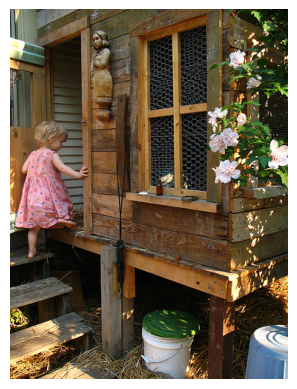

In [40]:
generate_caption("1000268201_693b08cb0e.jpg")

---------------------Actual---------------------
startseq girl is getting ready to swing the club endseq
startseq woman in shorts and blue sleeveless shirt leans over golf club endseq
startseq woman is taking swing with golf club endseq
startseq woman wearing blue shirt and hat with khaki shorts plays golf endseq
startseq woman wearing blue begins golf swing endseq
--------------------Predicted--------------------
startseq boy in shorts and shorts is running in the grass endseq


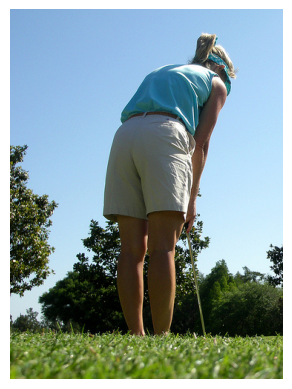

In [41]:
generate_caption("127490019_7c5c08cb11.jpg")

---------------------Actual---------------------
startseq about 12 kids and few adults get splashed by an off camera source endseq
startseq group of children are in water fountain endseq
startseq group of children standing in shallow pool of water endseq
startseq group of young kids play in the water on sunny day endseq
startseq children and adults play with sprinkler endseq
--------------------Predicted--------------------
startseq group of people in dresses endseq


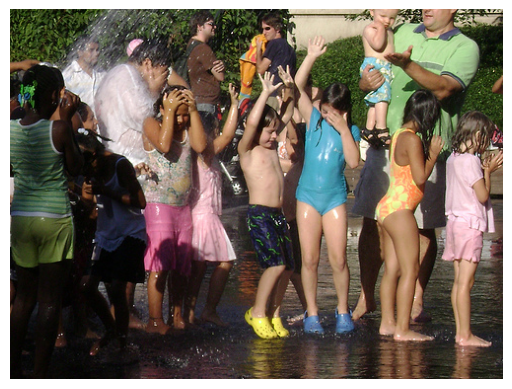

In [44]:
generate_caption("1273001772_1585562051.jpg")